In [1]:
from keras.preprocessing.text import Tokenizer
import random 
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
docs = ['this is a test ', 'this is also a test', 'why and I still testing this', 'ok now the test is over']


class SkipGram:
    def __init__(self, max_len=5, tokenizer=None):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.words = None
        self.probs = None
        self.n_words = None
        if tokenizer:
            self._setup_words()
        pass

    def _setup_words(self):
        self.n_words = sum(self.tokenizer.word_counts.values())
        self.words = np.array(list(self.tokenizer.word_counts.keys()))
        n = np.sum(list(self.tokenizer.word_counts.values()))
        self.probs= np.array(list(self.tokenizer.word_counts.values()))/n
        
    def fit(self, docs):
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(docs)
        self._setup_words()

    def _text_to_padded_sequences(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len, padding='post', truncating='post')
        return seqs_padded
    
    def text_to_seq(self, docs):
        seqs = self.tokenizer.texts_to_sequences(docs)
        seqs_padded = pad_sequences(seqs, maxlen=self.max_len-1, padding='post', truncating='post')
        return seqs_padded
    
    def _random_choice_int(self, v):
        new_word = np.random.choice(self.words, 1, p=self.probs)[0]
        output = self.tokenizer.word_index[new_word]
        if v == output:
            new_word = np.random.choice(self.words, 1, p=self.probs)[0]
            output = self.tokenizer.word_index[new_word]
        
        return output

    def _missing_word_gen(self, docs):
        seqs = self._text_to_padded_sequences(docs)
        for seq in seqs:
            seq = np.array(seq)
            if sum(seq) != 0:
                for i in range(self.max_len):
                    new_seq = np.delete(seq, i)
                    x = np.array([new_seq, new_seq])
                    word_index = seq[i]
                    new_word_index = self._random_choice_int(word_index)
                    context = np.array([[word_index], [new_word_index]])
                    label = np.array([[1], [0]])
                    yield x, context, label

    def array_to_texts(self, x):
        return list(s.tokenizer.sequences_to_texts_generator(x))
    
    def transform_gen(self, docs, batch_size=32, shuffle=True):
        if shuffle:
            random.shuffle(docs)
        gen = self._missing_word_gen(docs)
        try:
            while True:
                array_list = [next(gen) for _ in range(int(batch_size))]
                x = np.vstack([v[0] for v in array_list])
                context = np.vstack([v[1] for v in array_list])
                labels = np.vstack([v[2] for v in array_list]).flatten()
                yield x, context, labels
        except StopIteration:
            print('completed')

    def transform(self, docs):
        array_list = list(self._missing_word_gen(docs))
        x = np.vstack([v[0] for v in array_list])
        context = np.vstack([v[1] for v in array_list])
        labels = np.vstack([v[2] for v in array_list]).flatten()
        return x, context, labels

test_docs = ['this is a test', 'this is still a test', 'why am I still testing', '']
s = SkipGram(max_len = 7)
s.fit(test_docs)
test_x, test_context, test_labels = s.transform(test_docs)
list(zip(s.array_to_texts(test_x,), s.array_to_texts( test_context),test_labels ))[1:10]


Using TensorFlow backend.
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matthew/.local/lib/python3.6/site-packages/tensorflow/py

[('is a test', 'still', 0),
 ('this a test', 'is', 1),
 ('this a test', 'still', 0),
 ('this is test', 'a', 1),
 ('this is test', 'i', 0),
 ('this is a', 'test', 1),
 ('this is a', 'a', 0),
 ('this is a test', '', 1),
 ('this is a test', 'a', 0)]

## Download 2020 ICD 10 Codes from the CDC

In [2]:
from urllib import request as ur
import pandas as pd
import re
url = 'ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Publications/ICD10CM/2020/icd10cm_codes_2020.txt'
req = ur.Request(url)
file = ur.urlopen(req)


df = pd.read_csv(file,  header=None, sep='\t')

# parses out the code descripitions
docs = list(map(lambda x: re.sub('[A-Z][0-9]+', '', x).strip(), df.iloc[:, 0]))
# parest out the actuall codes 
codes = list(map(lambda x: re.search('[A-Z][0-9]+', x).group(), df.iloc[:, 0]))
 
print('n_docs: {}'.format(len(docs)))

n_docs: 72184


In [3]:
docs[1:10]

['Cholera due to Vibrio cholerae 01, biovar eltor',
 'Cholera, unspecified',
 'Typhoid fever, unspecified',
 'Typhoid meningitis',
 'Typhoid fever with heart involvement',
 'Typhoid pneumonia',
 'Typhoid arthritis',
 'Typhoid osteomyelitis',
 'Typhoid fever with other complications']

In [4]:
# calculated the max sequence len
max_len = np.max([len(d.split(' ')) for d in docs])
print('max length: {}'.format(max_len))

max length: 31


In [5]:
s = SkipGram(max_len=max_len)
s.fit(docs)
vocab_size = len(s.tokenizer.word_index)
context_size = 1
print('vocab size: {}'.format(vocab_size))

vocab size: 7212


In [6]:
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Flatten, Dense, BatchNormalization
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import skipgrams
from keras.callbacks import EarlyStopping
esm =  EarlyStopping(patience=2, monitor='loss')

dim_embedddings =10


# Context
c_inputs = Input(shape=(max_len-1,),  name='inputContext' , dtype='int32')
c_emb = Embedding(vocab_size+1, dim_embedddings, name= 'embContext', mask_zero=True)(c_inputs)

# Missing Word
w_inputs = Input(shape=(context_size,), name='inputMissingWord', dtype='int32')
w_emb  = Embedding(vocab_size+1, dim_embedddings, name= 'embMissingWord', mask_zero=True)(w_inputs)

# combine two inputs using dot product 
o = Dot(axes=2, name='dotproduct')([c_emb, w_emb ])
o = BatchNormalization(name='batch_norm')(o)
o = Flatten(name='flatten')(o)
o = Dense(1, name='output_dense')(o)
o = Activation('sigmoid', name='output_activation')(o)
model = Model(inputs=[c_inputs, w_inputs], outputs=o)
model.compile(loss='binary_crossentropy', optimizer='adam')

# define training function
def train(doc, epochs=1, batch_size=1024):
    n_batches = int(len(docs)/batch_size)
    for e in range(epochs):
        gen = s.transform_gen(docs, batch_size=batch_size)
        try:
            batch = 0
            while True:
                x, context, y = next(gen)
                model.train_on_batch([x, context], y)
                if batch % 100 == 0:
                    results = model.evaluate([x, context], y)
                    print('epoch {0}/{1} batch {2}/{3} results {4} ...'.format(e+1,epochs, batch,n_batches*100, results))
                batch +=1
        except StopIteration:
            print('training completed')
        

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputContext (InputLayer)       (None, 30)           0                                            
__________________________________________________________________________________________________
inputMissingWord (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
embContext (Embedding)          (None, 30, 10)       72130       inputContext[0][0]               
__________________________________________________________________________________________________
embMissingWord (Embedding)      (None, 1, 10)        72130       inputMissingWord[0][0]          

In [11]:
train(docs,10)

2048/2048 [==============================] - 0s 34us/step
epoch 1/10 batch 0/7000 results 0.11594571283785626 ...
2048/2048 [==============================] - 0s 34us/step
epoch 1/10 batch 100/7000 results 0.1071568273473531 ...
2048/2048 [==============================] - 0s 38us/step
epoch 1/10 batch 200/7000 results 0.09276195642451057 ...
2048/2048 [==============================] - 0s 35us/step
epoch 1/10 batch 300/7000 results 0.11311910568110761 ...
2048/2048 [==============================] - 0s 35us/step
epoch 1/10 batch 400/7000 results 0.10232272472785553 ...
2048/2048 [==============================] - 0s 33us/step
epoch 1/10 batch 500/7000 results 0.10276041389806778 ...
2048/2048 [==============================] - 0s 34us/step
epoch 1/10 batch 600/7000 results 0.08811020786379231 ...
2048/2048 [==============================] - 0s 34us/step
epoch 1/10 batch 700/7000 results 0.10198409321310464 ...
2048/2048 [==============================] - 0s 34us/step
epoch 1/10 batch 

2048/2048 [==============================] - 0s 30us/step
epoch 4/10 batch 400/7000 results 0.06188113030293607 ...
2048/2048 [==============================] - 0s 30us/step
epoch 4/10 batch 500/7000 results 0.08383020961264265 ...
2048/2048 [==============================] - 0s 30us/step
epoch 4/10 batch 600/7000 results 0.05399913438122894 ...
2048/2048 [==============================] - 0s 30us/step
epoch 4/10 batch 700/7000 results 0.08178149756986386 ...
2048/2048 [==============================] - 0s 31us/step
epoch 4/10 batch 800/7000 results 0.072484259322664 ...
2048/2048 [==============================] - 0s 30us/step
epoch 4/10 batch 900/7000 results 0.07504248095210642 ...
2048/2048 [==============================] - 0s 32us/step
epoch 4/10 batch 1000/7000 results 0.08441440259502997 ...
2048/2048 [==============================] - 0s 31us/step
epoch 4/10 batch 1100/7000 results 0.08317042576163658 ...
2048/2048 [==============================] - 0s 37us/step
epoch 4/10 bat

2048/2048 [==============================] - 0s 32us/step
epoch 7/10 batch 800/7000 results 0.03973816550751508 ...
2048/2048 [==============================] - 0s 31us/step
epoch 7/10 batch 900/7000 results 0.05649869722810763 ...
2048/2048 [==============================] - 0s 30us/step
epoch 7/10 batch 1000/7000 results 0.047679686446372216 ...
2048/2048 [==============================] - 0s 31us/step
epoch 7/10 batch 1100/7000 results 0.05128015161244548 ...
2048/2048 [==============================] - 0s 31us/step
epoch 7/10 batch 1200/7000 results 0.03489721872028895 ...
2048/2048 [==============================] - 0s 30us/step
epoch 7/10 batch 1300/7000 results 0.051277791177199106 ...
2048/2048 [==============================] - 0s 31us/step
epoch 7/10 batch 1400/7000 results 0.04697770480981944 ...
2048/2048 [==============================] - 0s 29us/step
epoch 7/10 batch 1500/7000 results 0.04297831187477641 ...
2048/2048 [==============================] - 0s 31us/step
epoch 

In [42]:
seqs = s.text_to_seq(docs)

30

In [59]:
def get_enoder():
    inputs = Input(shape=(None,),  name='inputContext' , dtype='int32')
    outputs= Embedding(vocab_size+1, dim_embedddings, name= 'emb', mask_zero=True)(inputs)
    m = Model(inputs=inputs, outputs=outputs)
    m.get_layer('emb').set_weights(model.get_layer('embContext').get_weights())
    m.layers[-1].trainable = False
    return m
encoder = get_enoder() 
encoder.summary()
encoder.predict(np.array(seqs[1:10]))


vects = encoder.predict(seqs)
vects.shape

vects_reshaped = np.reshape(vects, (-1, 300))

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputContext (InputLayer)    (None, None)              0         
_________________________________________________________________
emb (Embedding)              (None, None, 10)          72130     
Total params: 72,130
Trainable params: 0
Non-trainable params: 72,130
_________________________________________________________________


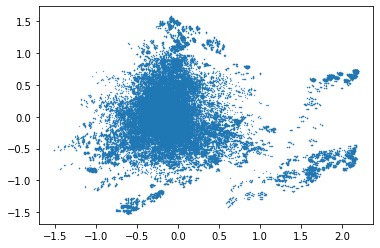

In [61]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
p = PCA(2).fit(vects_reshaped)
comps = p.transform(vects_reshaped)
xx = comps[:, 0]
yy = comps[:, 1]
plt.scatter(xx, yy,s=.1)
plt.show()

In [62]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(5)
nn = nn.fit(comps)

In [110]:
def predict_comps(docs):
    seqs = s.text_to_seq(docs)
    vects = encoder.predict(seqs)
    vects_reshaped = np.reshape(vects, (-1, 300))
    comps = p.transform( vects_reshaped )
    distances, indices = nn.kneighbors(comps)
    return [codes[w] for w in indices.flatten()]

predict_comps(['septic shock sepsis'])

['S82422', 'T65212', 'T373', 'S82144', 'S1085']

In [106]:
s.tokenizer.index_word

{1: 'of',
 2: 'encounter',
 3: 'fracture',
 4: 'unspecified',
 5: 'subsequent',
 6: 'with',
 7: 'for',
 8: 'other',
 9: 'initial',
 10: 'left',
 11: 'right',
 12: 'sequela',
 13: 'and',
 14: 's',
 15: 'a',
 16: 'or',
 17: 'd',
 18: 'in',
 19: 'open',
 20: 'type',
 21: 'healing',
 22: 'displaced',
 23: 'nondisplaced',
 24: 'to',
 25: 'injury',
 26: 'lower',
 27: 'closed',
 28: 'shaft',
 29: 'level',
 30: 'injured',
 31: 'at',
 32: 'by',
 33: 'delayed',
 34: 'routine',
 35: 'nonunion',
 36: 'body',
 37: 'arm',
 38: 'i',
 39: 'ii',
 40: 'hand',
 41: 'femur',
 42: 'without',
 43: 'finger',
 44: 'accident',
 45: 'end',
 46: 'malunion',
 47: 'iiia',
 48: 'iiib',
 49: 'iiic',
 50: 'foot',
 51: 'degree',
 52: 'foreign',
 53: 'laceration',
 54: 'leg',
 55: 'specified',
 56: 'upper',
 57: 'collision',
 58: 'due',
 59: 'wrist',
 60: 'eye',
 61: 'effect',
 62: 'poisoning',
 63: 'muscle',
 64: 'xa',
 65: 'xd',
 66: 'xs',
 67: 'vehicle',
 68: 'k',
 69: 'g',
 70: 'bone',
 71: 'tibia',
 72: 'radius',


In [ ]:



# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")
 
# # later...
 
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
 
    
    